## Урок 11. Jupyter Notebook и несколько слов об аналитике

$f(x) = -12x^4 \cdot sin(cos(x)) - 18x^3+5x^2 + 10x - 30$

- Определить корни
- Найти интервалы, на которых функция возрастает
- Найти интервалы, на которых функция убывает
- Построить график
- Вычислить вершину
- Определить промежутки, на котором f > 0
- Определить промежутки, на котором f < 0

In [1]:
import numpy as np
import pandas as pd
import sympy as sym

from matplotlib import pyplot as plt
%config InlineBackend.figure_format='retina'

### Общее исследование

In [2]:
x = sym.Symbol('x')
fx = -12*x**4 * sym.sin(sym.cos(x)) - 18*x**3 + 5*x**2 + 10 * x - 30
fx

-12*x**4*sin(cos(x)) - 18*x**3 + 5*x**2 + 10*x - 30

Странный задан многочлен, конечно. Немного нестандартный. Посмотрим на график, потом попробуем определить корни солвером:

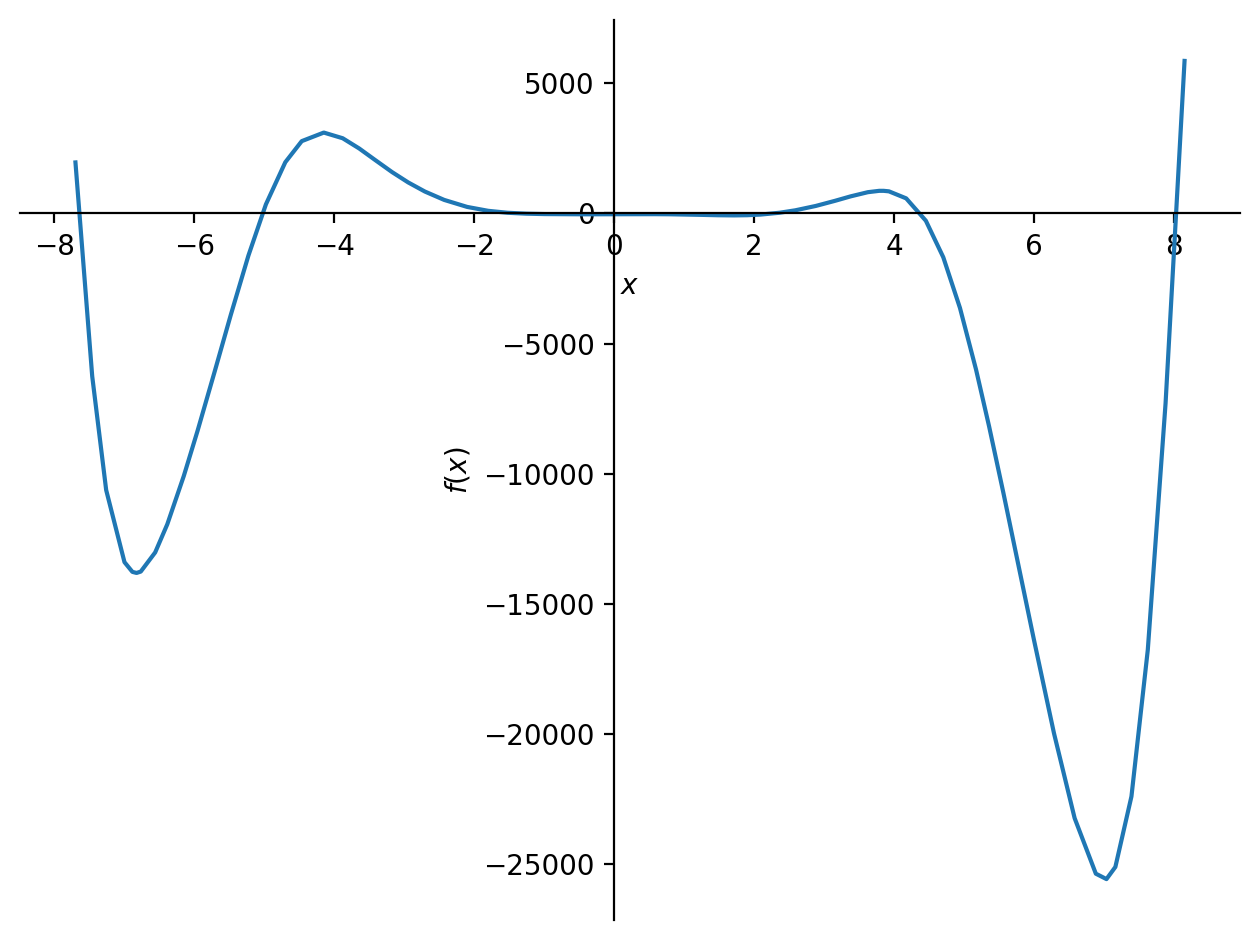

In [3]:
sym.plotting.plot(fx, (x, -7.7, 8.15));

Да уж, не слабо колбасит нашу функцию. Попробуем определить множество корней:

In [4]:
sym.solveset(fx, x)

ConditionSet(x, Eq(-12*x**4*sin(cos(x)) - 18*x**3 + 5*x**2 + 10*x - 30, 0), Complexes)

Если я правильно прочитал, то корни принадлежат множеству комплексных чисел, когда многочлен равен нулю. Что - логично 🙂

Беда наступает при попытке найти знаки постоянства солвером:

In [5]:
sym.solve_univariate_inequality(fx>0, x)

NotImplementedError: 
The inequality, -12*x**4*sin(cos(x)) - 18*x**3 + 5*x**2 + 10*x - 30 >
0, cannot be solved using solve_univariate_inequality.

Здесь придется использовать приблизительные методы (теми же методами определю и корни) 🙂

### Общие настройки

In [6]:
def calc_function_score(x, a, b, c, d, e):
    return np.around(a*x**4 * np.sin(np.cos(x)) + b*x**3 + c*x**2 + d * x + e, 8)

In [7]:
coefs = [-12, -18, 5, 10, -30]

In [8]:
l_lim = -1.8
r_lim = 2.5
step = 0.00006

Я буду исследовать участок кривой в диапазоне от -1.8 до 2.5

In [9]:
df = pd.DataFrame()
df['x'] = np.arange(l_lim, r_lim, step)
df['y'] = df['x'].apply(calc_function_score, args=(coefs))
df.head()

,x,y
0,-1.80000,101.551316
1,-1.79994,101.529385
2,-1.79988,101.507457
3,-1.79982,101.485532
4,-1.79976,101.463609


### Найти корни

In [10]:
df['roots'] = False
df.loc[np.around(df['y'], 2)==0, 'roots'] = True

np.around(df[df['roots']], 2)

,x,y,roots
7684,-1.34,-0.0,True
67884,2.27,-0.0,True


Корней на нашем участке 2. Проверим:

In [11]:
def get_axes(x_name='x', y_name='y', root_name='toots', print_main=True):
    fig, ax = plt.subplots(figsize=(8, 6))
    bins = np.around(np.arange(l_lim, r_lim+0.01, 0.25), 2)

    if print_main:
        ax.plot(df[x_name], df[y_name], color='deepskyblue', zorder=0)
    
    ax.axhline(y=0, color='gray', ls=':', zorder=0)    
    ax.scatter(df.loc[df['roots'], x_name], df.loc[df['roots'], y_name], 
                        c='cornflowerblue', edgecolor='black', marker='X', zorder=10, label='Корни', s=100)
    ax.set_xticks(bins)
    ax.set_xticklabels(bins, rotation=90)
    ax.grid(ls=':', color='lightgray')
    ax.set_axisbelow(True)
    ax.set_title('Исследование заданной функции')
    return ax

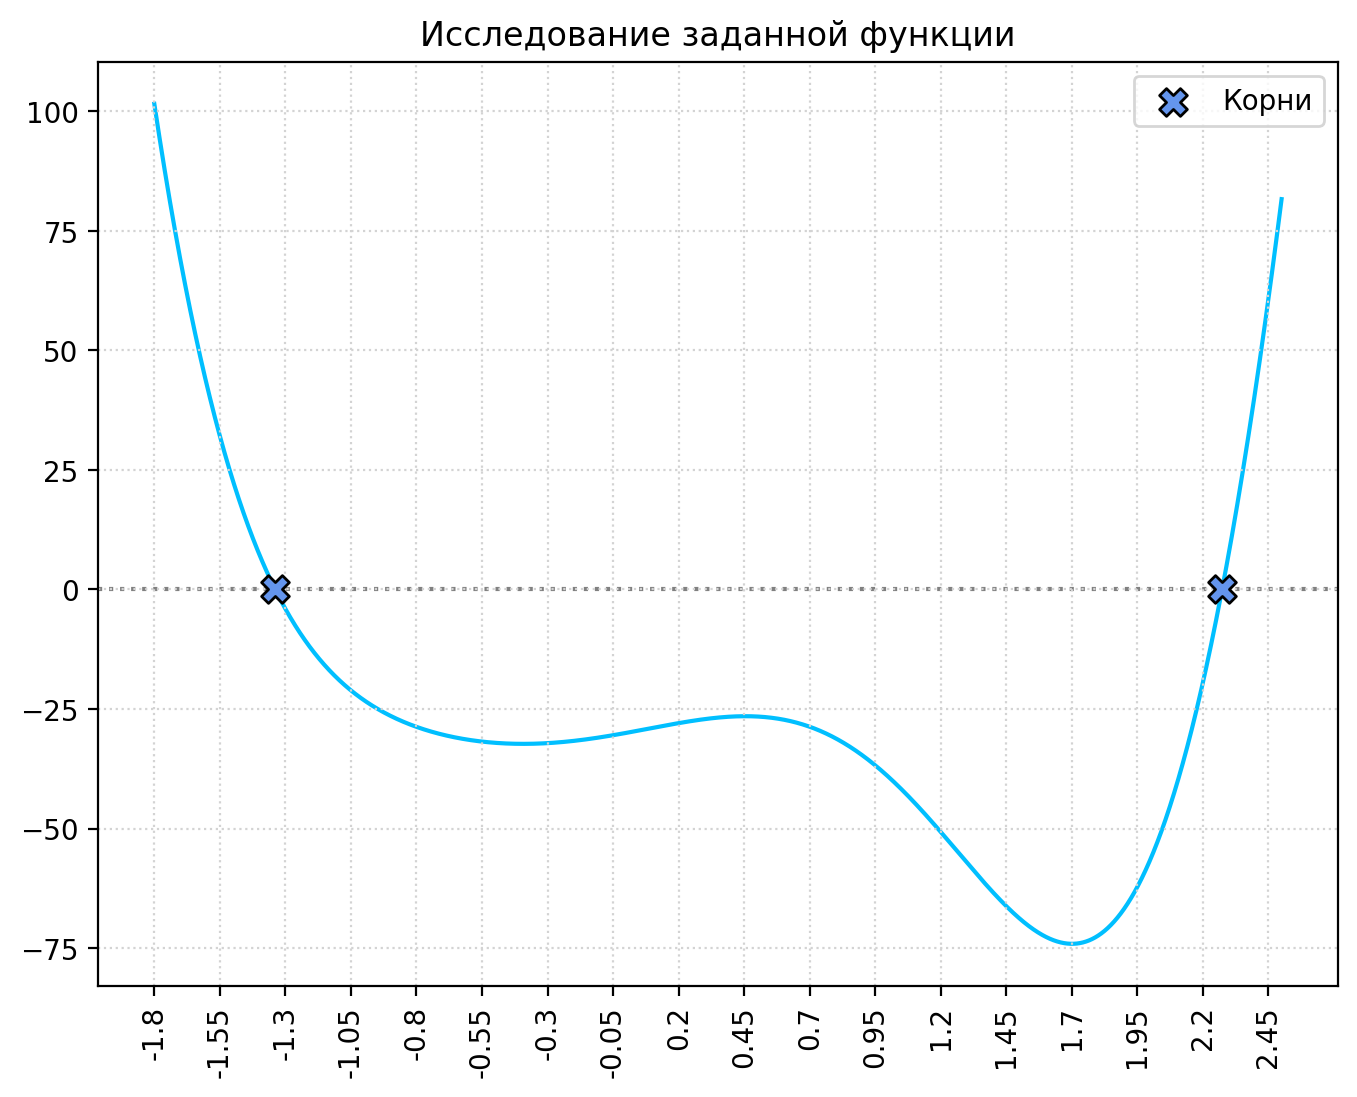

In [12]:
ax = get_axes()
ax.legend();

А теперь пойдем не по бумажке 🙂
1. Найдем точки экстремумов
2. Определим интервлы возрастания/убывания
3. Определим знак функции
4. Определим глобальный минимум участка

### Точки экстремумов

In [13]:
tmp = df[['y']].shift(1).rename(columns={'y': 'prev_y'})
df = df.merge(tmp, left_index=True, right_index=True)

tmp = df[['y']].shift(-1).rename(columns={'y': 'next_y'})
df = df.merge(tmp, left_index=True, right_index=True)

In [14]:
flt_1 = (df['prev_y'] >= df['y']) & (df['y'] < df['next_y'])
flt_2 = (df['prev_y'] <= df['y']) & (df['y'] > df['next_y'])
flt_3 = (df['prev_y'].isnull()) | (df['next_y'].isnull())

In [15]:
df['is_extr'] = False
df.loc[flt_1 | flt_2 | flt_3, 'is_extr'] = True

df.loc[df['is_extr'], ['x', 'y']]

,x,y
0,-1.80000,101.551316
23455,-0.39270,-32.293580
37576,0.45456,-26.512722
58343,1.70058,-74.106293
71666,2.49996,81.616678


Экстремумов, если считать и пограничные точки интервала, всего 5. Отрисуем их на графике:

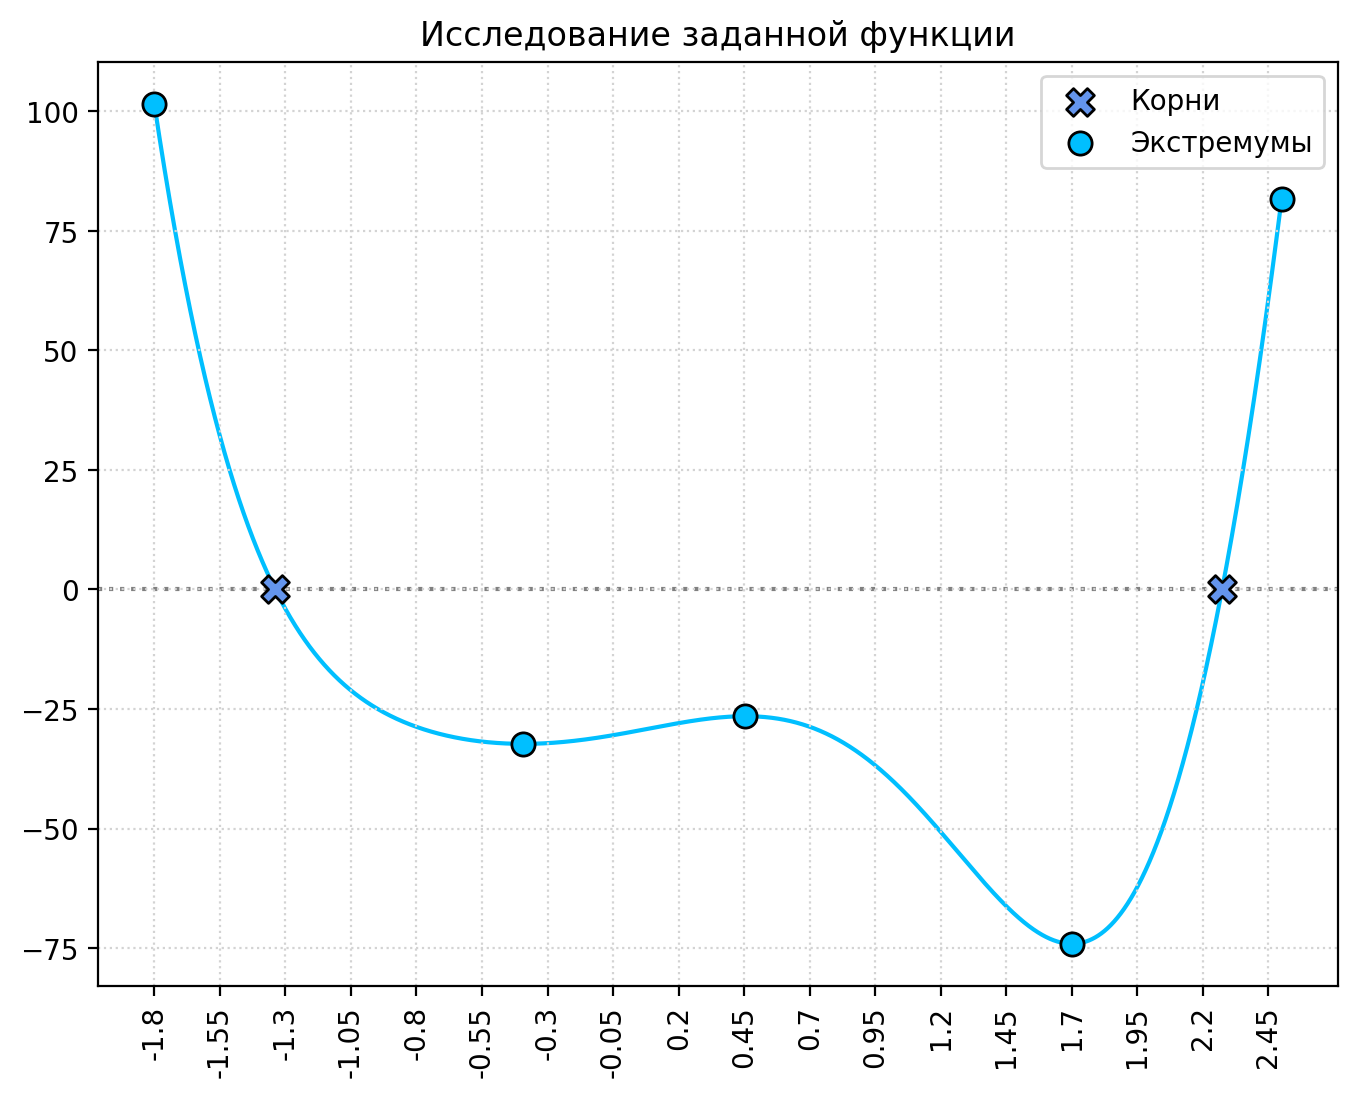

In [16]:
ax = get_axes()

ax.scatter(df.loc[df['is_extr'], 'x'], df.loc[df['is_extr'], 'y'], 
                               c='deepskyblue', edgecolor='black', s=70, zorder=10, label='Экстремумы')
ax.legend();

### Интервалы возрастания/убывания

In [17]:
df['direction'] = (df['y'] - df['next_y']).apply(lambda x: -1 if x > 0 else 1)
df[['x', 'y', 'direction']].head()

,x,y,direction
0,-1.80000,101.551316,-1
1,-1.79994,101.529385,-1
2,-1.79988,101.507457,-1
3,-1.79982,101.485532,-1
4,-1.79976,101.463609,-1


Отлично, направления у нас есть, теперь нужно разбить на отрезки и раскрасить 🙂

In [18]:
df.loc[df['is_extr'], 'segment'] = df.loc[df['is_extr']].index
df['segment'] = df['segment'].fillna(method='ffill').astype('int64')

In [19]:
def get_axes_rebuild():
    ax = get_axes(print_main=False)
    pos_params = {
        'color': 'forestgreen',
        'label': 'Участки возрастания'
    }

    neg_params = {
        'color': 'red',
        'label': 'Участки убывания'
    }

    ax.scatter(df.loc[df['is_extr'], 'x'], df.loc[df['is_extr'], 'y'], 
                               c='deepskyblue', edgecolor='black', s=70, zorder=10, label='Экстремумы')
    for i in df['segment'].unique():
        tmp = df[df['segment']==i].copy()
        direct = tmp['direction'].unique()[0]
    
        if direct > 0:
            ax.plot(tmp['x'], tmp['y'], zorder=1, **pos_params)
            pos_params.pop('label', None)
        else:
            ax.plot(tmp['x'], tmp['y'], zorder=1, **neg_params)
            neg_params.pop('label', None)
    
    return ax

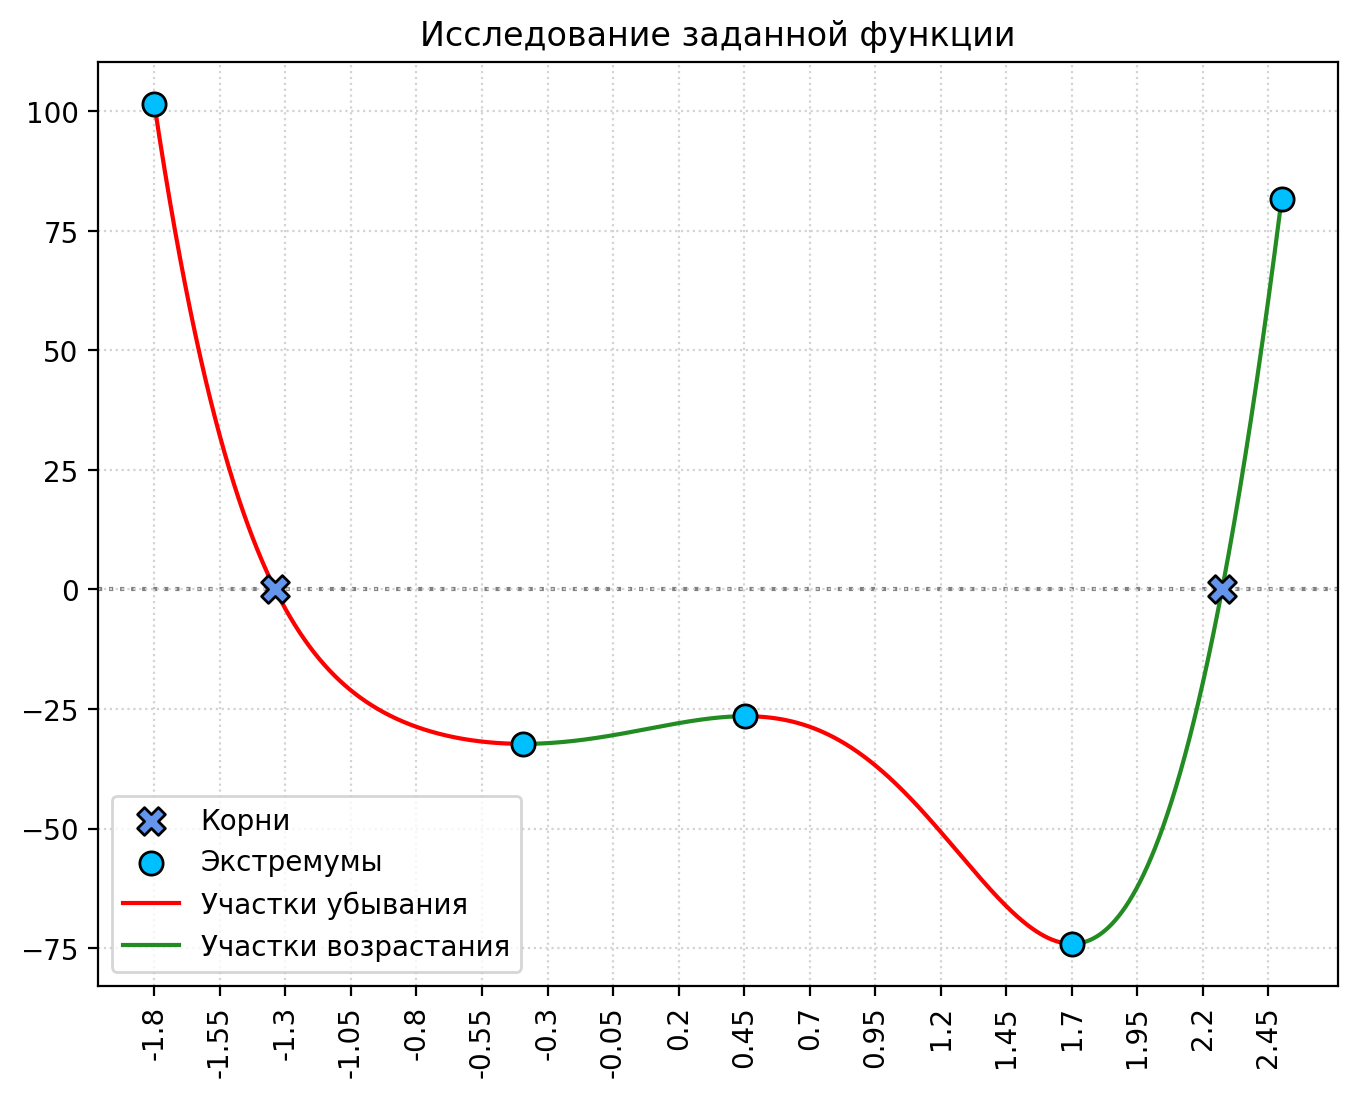

In [20]:
ax = get_axes_rebuild()

ax.legend();

### Знак функции

Здесь мы просто раскрасим поле графика

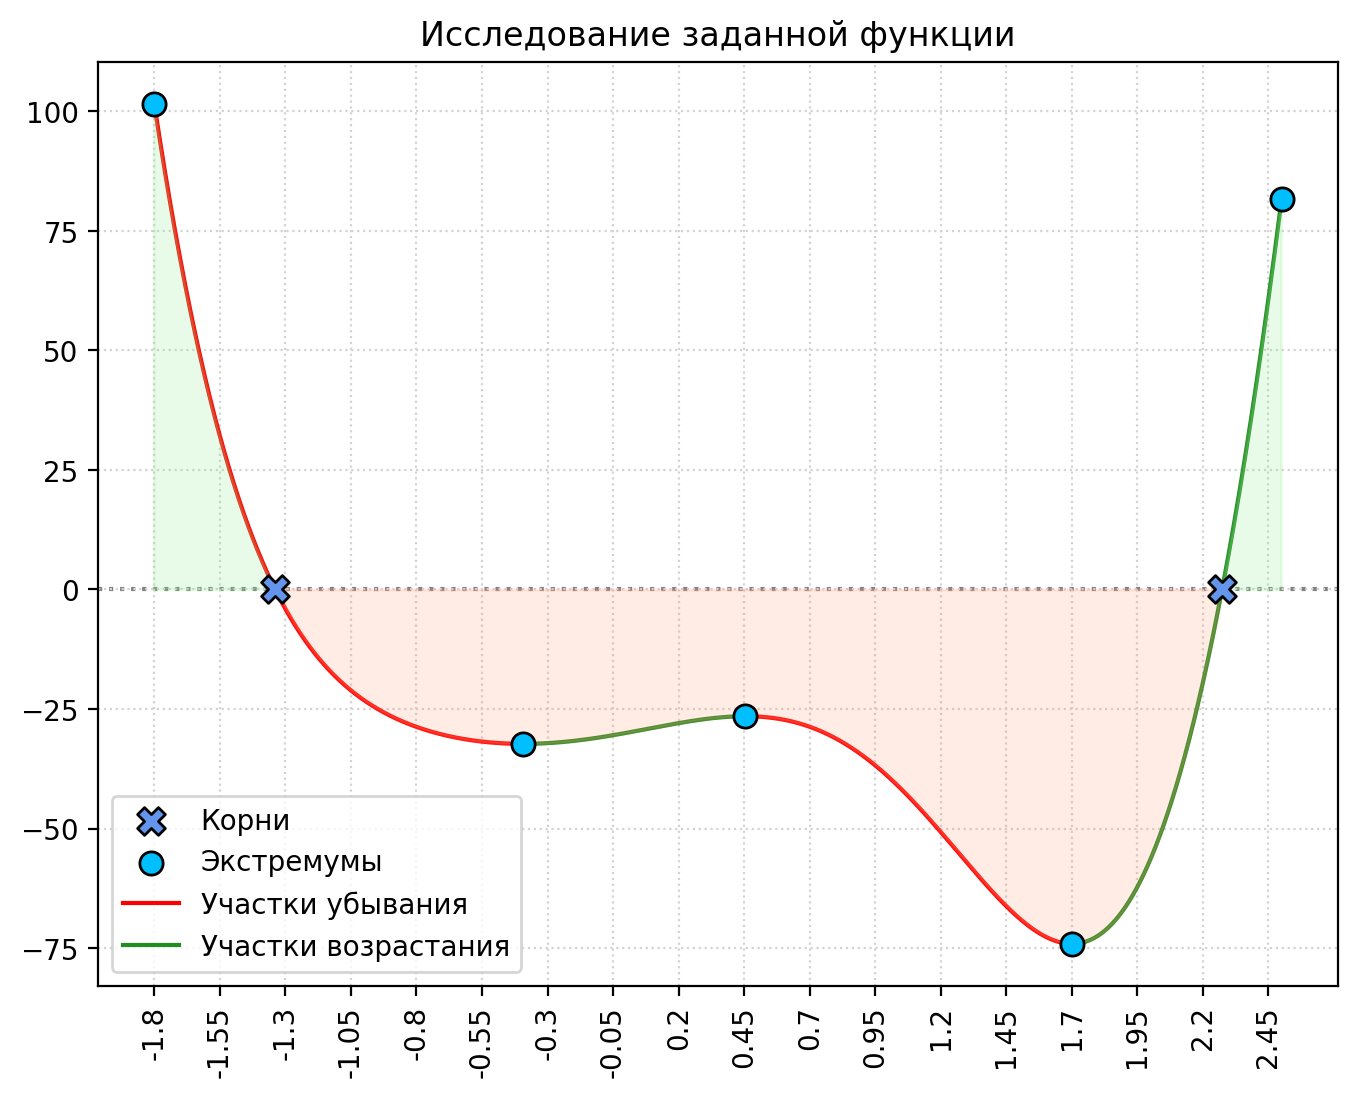

In [21]:
ax = get_axes_rebuild()

ax.fill_between(df['x'], 0, df['y'], where=df['y']>0, color='lightgreen', alpha=0.2)
ax.fill_between(df['x'], 0, df['y'], where=df['y']<0, color='lightsalmon', alpha=0.2)

ax.legend();

Ну вот. Как-то так. Осталось найти глобальный минимум участка.

### Определить глобальный минимум участка

In [22]:
point_min = df[df['y']==df['y'].min()].copy()

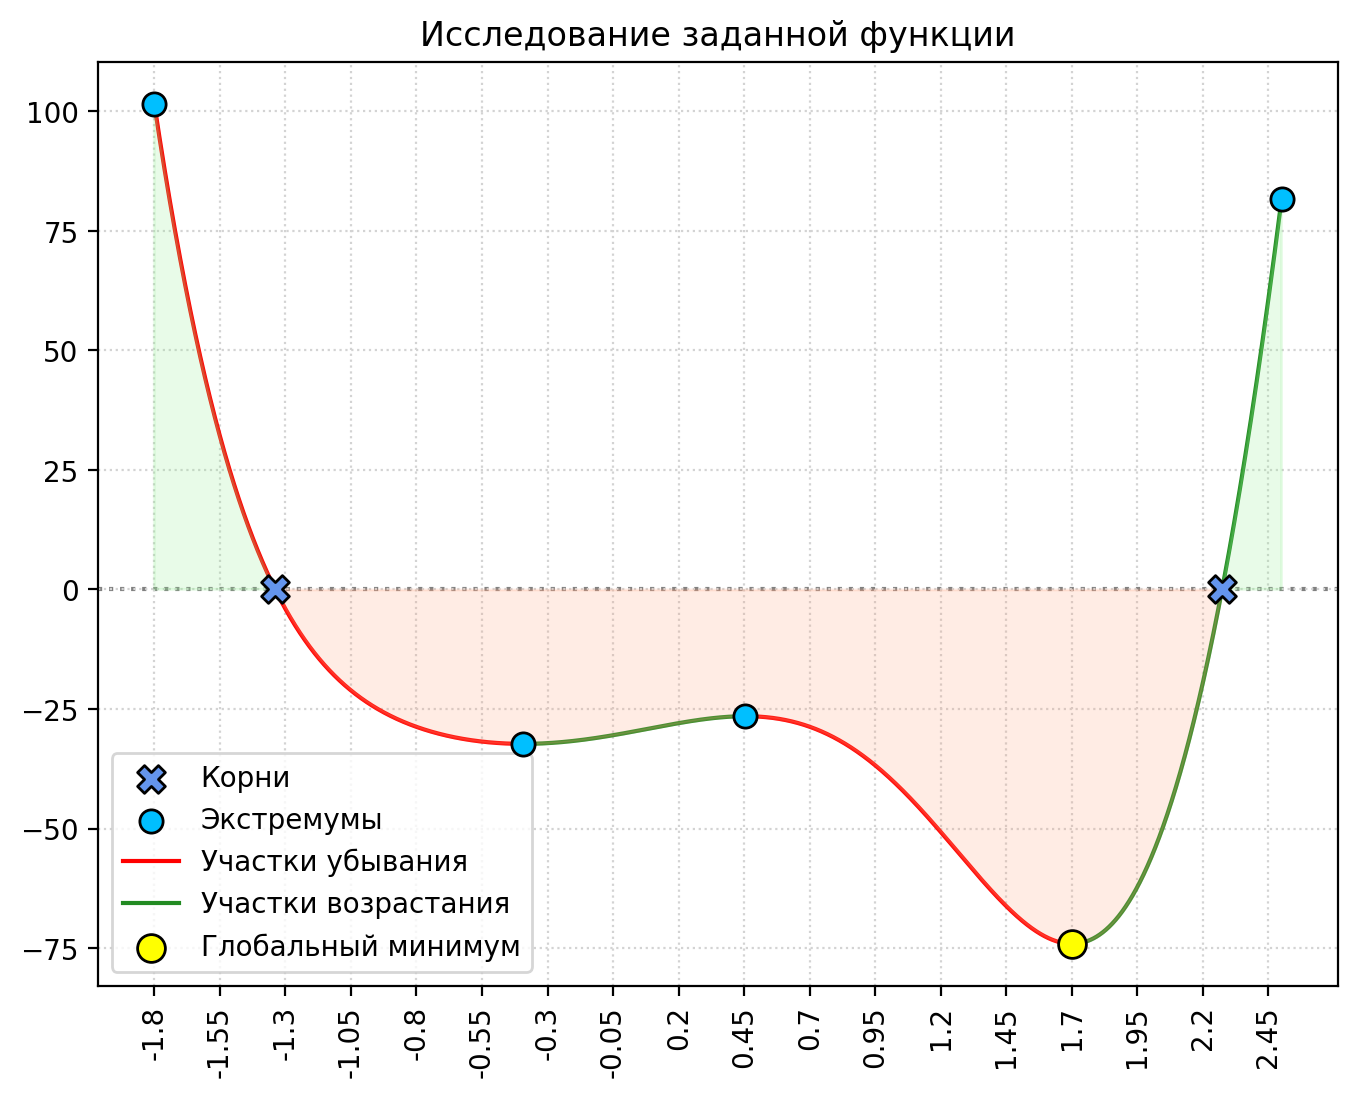

In [23]:
ax = get_axes_rebuild()

ax.fill_between(df['x'], 0, df['y'], where=df['y']>0, color='lightgreen', alpha=0.2)
ax.fill_between(df['x'], 0, df['y'], where=df['y']<0, color='lightsalmon', alpha=0.2)

ax.scatter(point_min['x'], point_min['y'], s=100, marker='o', 
                   zorder=15, c='yellow', edgecolor='black', label='Глобальный минимум')

ax.legend();